# An Introduction to ML

## The ML Pipeline

* Data organization: Organize the data into vectors of features
* Model selection: What is your question? What is your Loss function
* Feature selection: Also known as model regularization
* Model fitting: Tune the model’s parameters to reduce loss
* Model validation: What is its error? Does it generalize?


In [30]:
import os
import random
import numpy as np
import scipy.optimize as opt
import scipy.stats as stat
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import sklearn as sk
import sklearn.cluster as clust
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from tqdm.notebook import tqdm
import seaborn as sns
sns.set(style="whitegrid")

## Data Organization

All of the examples will use the same dataset, collected in this lab by graduate student Holly Hake. The dataset containss data from 51 elderly adults. The _features_ of the data are age (in years), sex (M or F), and Speed of Foregetting (SoF), a measure of long-term memory function. In addition, each person has been clinically diagnoses as either suffering from Mild Cognitive Impairment (MCI) or being a Healthy Control (HC). 

In [32]:
data = pd.read_csv("../holly.csv")
data

,userId,clinicalStatus,age,sex,sof
0,69409,HC,72,F,0.378611
1,69410,HC,58,F,0.364693
2,69411,MCI,75,M,0.441768
3,69412,MCI,70,M,0.467389
4,69414,HC,72,F,0.334343
5,69415,MCI,67,M,0.435315
6,69417,MCI,73,M,0.391745
7,69418,MCI,70,M,0.398536
8,69419,HC,57,F,0.361850
9,69420,HC,73,M,0.364266


We will mostly focus on the _age_ and _SoF_ features. This is what the observations look like when they are plotted across these two dimensions

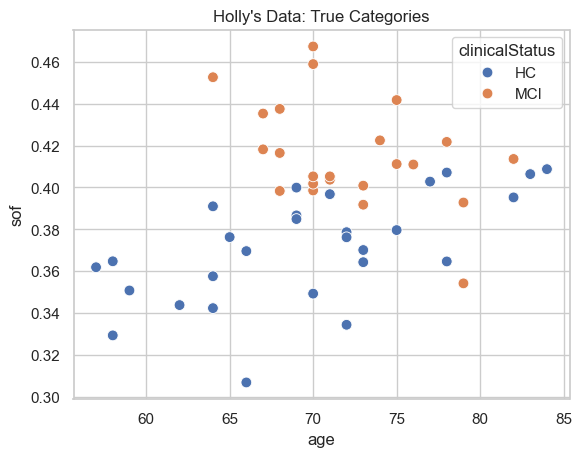

In [34]:
ax = sns.scatterplot(data, x="age", y="sof", hue="clinicalStatus", s=60)
ax.set_title("Holly's Data: True Categories")
plt.show()

Create matrix _X_ of data.

In [36]:
dataX = data[["age","sof"]]
dataX

,age,sof
0,72,0.378611
1,58,0.364693
2,75,0.441768
3,70,0.467389
4,72,0.334343
5,67,0.435315
6,73,0.391745
7,70,0.398536
8,57,0.361850
9,73,0.364266


### Scaling your variables

In [38]:
dataX['age_zscore'] = (dataX.age - dataX.age.mean()) / dataX.age.std(ddof=0)
dataX['sof_zscore'] = (dataX.sof - dataX.sof.mean()) / dataX.sof.std(ddof=0)
dataZ = dataX[['age_zscore','sof_zscore']]
dataX = dataX[['age','sof']]
dataZ

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_91878/1083979225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['age_zscore'] = (dataX.age - dataX.age.mean()) / dataX.age.std(ddof=0)
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_91878/1083979225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX['sof_zscore'] = (dataX.sof - dataX.sof.mean()) / dataX.sof.std(ddof=0)


,age_zscore,sof_zscore
0,0.196421,-0.382386
1,-1.994898,-0.799591
2,0.665989,1.510666
3,-0.116625,2.278641
4,0.196421,-1.709272
5,-0.586193,1.317241
6,0.352943,0.011291
7,-0.116625,0.214844
8,-2.151420,-0.884803
9,0.352943,-0.812363


# Supervised Learning Methods

Supervised learning methods learn from a set of labelled data, i.e., data for which the ground truth is provided. 

## Linear Regression

This is the model we are all familiar with from Stats classes. And, yes, it can be used for ML---in fact, it is one of the most common methods!

### The Theory

In linear regression, we are trying to model our data $Y$ as a linear function of our variables $X = {x_1, x_2, ... x_N}$ using a linear function of the form:

$$ Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_N x_N$$

### The Loss function

The loss function in linear regression is the _sum of squares_, i.e., the sum of the squared differences between obsered data _Y_ and the model's predictions _Y*_:

$$ L = \sum_{i=1}^N (Y_i - Y^*_i)^2 $$

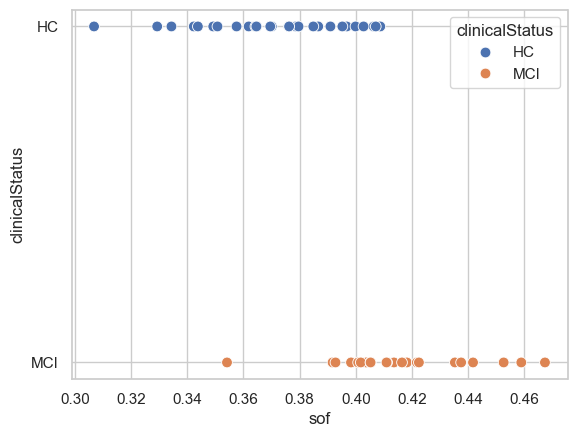

In [41]:
classes = [0 if x == "HC" else 1 for x in data.clinicalStatus ]
ax=sns.scatterplot(data, y="clinicalStatus", x="sof", s=60, hue="clinicalStatus")
plt.show()

In [48]:
newobs = [80, 0.35]
newobs_z = [(newobs[0] - data.age.mean())/data.age.std(),
            (newobs[1] - data.sof.mean())/data.sof.std()]
x, y = newobs_z
point = pd.DataFrame({"age":newobs[:-1], "sof":newobs[1:]}) #np.array([newobs]).reshape((1,2))
point_z = pd.DataFrame({"age_zscore":newobs_z[:-1], "sof_zscore":newobs_z[1:]}) #np.array([newobs]).reshape((1,2))

first, we need to transform categorical variables as numbers

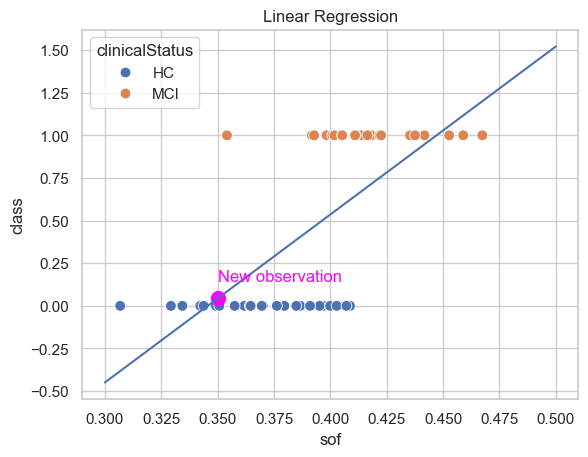

In [92]:
lm = sk.linear_model.LinearRegression()
lm.fit(dataX[['sof']], classes)
data['class'] = classes
ax = sns.scatterplot(data, y="class", x="sof", s=60, hue="clinicalStatus")
b0 = lm.intercept_
b1 = lm.coef_[0]
x = np.linspace(0.3, 0.5)
pred = b0 + b1 * x
ax.plot(x, pred)
ax.set_title("Linear Regression")

xpred = point[['sof']]
ypred = lm.predict(point[['sof']])
ax.text(newobs[1], ypred+0.1, s="New observation", color="magenta")
ax.scatter(xpred, ypred, s=100, color='magenta')
plt.show()

## Logistic Regression

Applying Linear Regression can sometimes lead to bizarre results. For example, an individual with an `sof` value of 0.3 would have a predicted `class` value of -0.5; not only this is neither 0 nor 1, but it is actually _outside_ of the range of class values. But even with values that are in-between 0 and 1, how should we interpret them? An individual with an `sof` of 0.4, for example, has a `class` value that just above 0.5; does that mean that the individual has >50% chances of belonging to the MCI class?

Logistic Regression is a method designed to address all of these questions in the case of binary classification problems. Logistic regression works like linear regression, but always returns values between 0 and 1, and these values can always be interpreted as probability of class assignments. 

### The Theory

Logistic regression can be thought as Linear Regression with an extra layer. Like in normal regression, the data is modeled as the sum of of different weighted features. Unlike normal regression, however, this sum does not represent the class values _Y_ directly; rather it represents an intermediate result, _U_:

$$ U = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_N x_N$$

The class data _Y_, instead, is modeled as a logistic function of _U_:

$$ Y = 1 / (1 + e^{U}) $$


### The Loss Function

The loss function is the same as canonical regression, i.e. the sum of squares:

$$ L = \sum_{i=1}^N (Y_i - Y^*_i)^2 $$ 


In [ ]:
logm = sk.linear_model.LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logm.fit(data[['sof']], classes)

# Create predictions for arbitrary values
newx = pd.DataFrame({'sof':list(np.linspace(0.3, 0.5))})
newy = logm.predict_proba(newx)

ax=sns.scatterplot(data, y="class", x="sof", s=60, hue="clinicalStatus")
ax.plot(newx, newy[:,1])
ax.set_title("Logistic Regression")
plt.show()

# Model Evaluation

How well does a model do? After a model has been _fit_ to the data, its performance can be evaluated against the data itself. 

## Model Fit

"Fit" is the term used to indicate how well the model explains the data it was trained on.


### The Model's Score

Because a model is fit by minimizing its Loss function, the value of the Loss function after fitting is a natural measure of fit. In Python's `scikit-learn` package, This value is stored in the `score` attribute of the fitted model.

### Universal Measure for Classification Accuracy

A model's score depends on the specific loss function. However, we want to know 

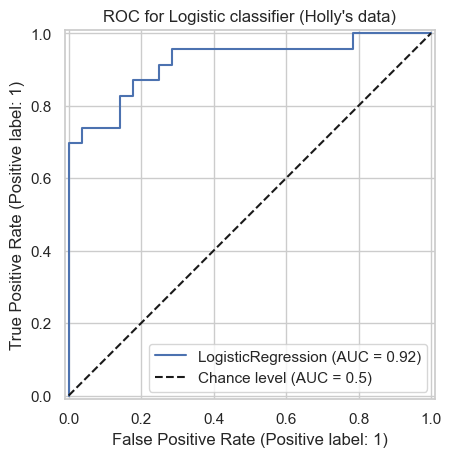

In [102]:
logm = sk.linear_model.LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logm.fit(dataZ, classes)

fig, ax = plt.subplots(1)
RocCurveDisplay.from_estimator(logm, dataZ, classes, ax=ax, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for Logistic classifier (Holly's data)")
plt.show()

## Generalizability

Validating the model against the data itself leads to inflated values. After all, a model should be judged against its ablity to predict _unseen_ data (generalization). This process is called _validation_.

### Validation

The simplest validation method is to split the data into _train_ and _test_ datasets.

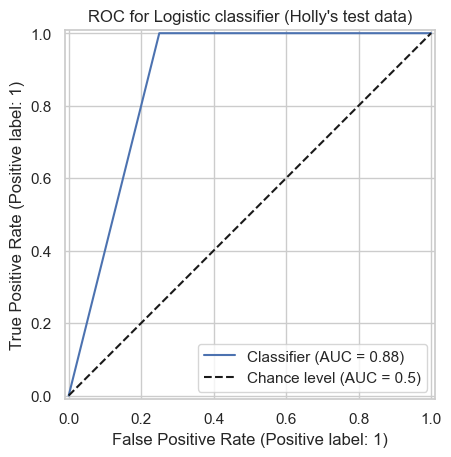

In [104]:
X_train, X_test, y_train, y_test = train_test_split(dataX, classes, random_state=0)
logm.fit(X_train, y_train)
fig, ax = plt.subplots(1)
y_predict = logm.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_predict, ax=ax, pos_label=None, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for Logistic classifier (Holly's test data)")
plt.show()

In [140]:
svm = sk.svm.LinearSVC()
svm.fit(dataX, classes)

LinearSVC()

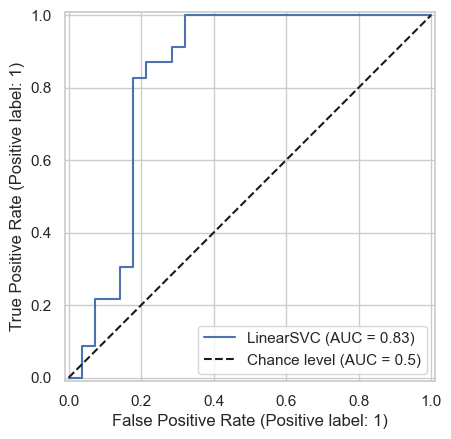

In [142]:
fig, ax = plt.subplots(1)
RocCurveDisplay.from_estimator(svm, dataX, classes, ax=ax, plot_chance_level=True)

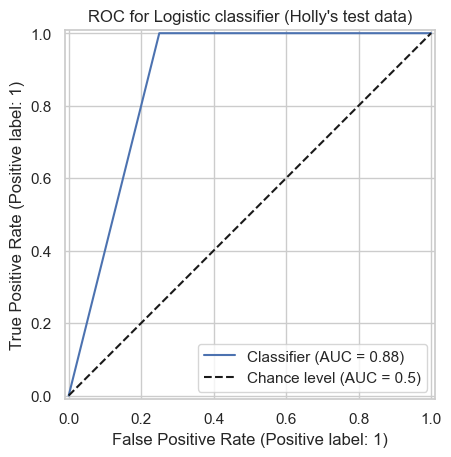

In [144]:
X_train, X_test, y_train, y_test = train_test_split(dataX, classes, random_state=0)
svm.fit(X_train, y_train)
fig, ax = plt.subplots(1)
y_predict = logm.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_predict, ax=ax, pos_label=None, plot_chance_level=True)
ax.set_aspect('equal')
ax.set_title("ROC for Logistic classifier (Holly's test data)")
plt.show()